In [ ]:
# Title = Development of a Julia-Based Tool to Aid in Solving a Finite Element Analysis Problem


In [3]:
import Pkg
Pkg.activate(".")

  Activating project at `c:\Users\Ciara Woellhof\Downloads`


In [4]:
Pkg.add(["Plots","LinearAlgebra","Random","DataFrames","Flux","StatsBase","Statistics","MLJ","MLJDecisionTreeInterface","MLJBase"])

    Updating registry at `C:\Users\Ciara Woellhof\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Ciara Woellhof\Downloads\Project.toml`
  No Changes to `C:\Users\Ciara Woellhof\Downloads\Manifest.toml`
Precompiling project...
  17006.1 ms  ? GridapODEs


In [5]:
using LinearAlgebra
using Plots
using Random
using DataFrames
# using Flux
# using Flux.Optimisers
# using StatsBase
# using Statistics
using MLJ
using MLJDecisionTreeInterface
import MLJDecisionTreeInterface
import MLJBase: fit!, predict


In [6]:
# Load the DecisionTreeRegressor from the DecisionTree package
DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree

[ Info: For silent loading, specify `verbosity=0`. 


import MLJDecisionTreeInterface ✔


MLJDecisionTreeInterface.DecisionTreeRegressor

In [7]:
# Load the DecisionTreeRegressor from the DecisionTree package
model = MLJDecisionTreeInterface.DecisionTreeRegressor()

DecisionTreeRegressor(
  max_depth = -1, 
  min_samples_leaf = 5, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = 0, 
  post_prune = false, 
  merge_purity_threshold = 1.0, 
  feature_importance = :impurity, 
  rng = TaskLocalRNG())

In [10]:

# Beam Finite Element Analysis struct for solving beam bending problems

struct BeamFEA
    length::Float64
    num_elements::Int
    young_modulus::Float64
    moment_inertia::Float64
    element_length::Float64

    # Constructor
    function BeamFEA(length::Float64, num_elements::Int, 
                     young_modulus::Float64, moment_inertia::Float64)
        new(length, num_elements, young_modulus, moment_inertia, 
            length / num_elements)
    end
end


In [11]:


# Compute the element stiffness matrix for a beam element

# Arguments
# beam: BeamFEA struct containing beam properties

function compute_element_stiffness(beam::BeamFEA)
    L = beam.element_length
    EI = beam.young_modulus * beam.moment_inertia

    # 4x4 element stiffness matrix for Euler-Bernoulli beam
    k = [
        12/L^3     6/L^2    -12/L^3    6/L^2;
        6/L^2      4/L      -6/L^2     2/L;
        -12/L^3   -6/L^2    12/L^3    -6/L^2;
        6/L^2      2/L      -6/L^2     4/L
    ] * EI

    return k
end


compute_element_stiffness (generic function with 1 method)

In [12]:


# Assemble global stiffness matrix for the beam

# Arguments
# beam: BeamFEA struct

function assemble_global_stiffness(beam::BeamFEA)
    # Total degrees of freedom
    total_dof = 2 * (beam.num_elements + 1)
    K = zeros(total_dof, total_dof)
    
    # Get element stiffness matrix
    k_element = compute_element_stiffness(beam)
    
    # Assembly process
    for i in 1:beam.num_elements
        # Map local DOFs to global
        idx = [2*i-1, 2*i, 2*i+1, 2*i+2]
        
        # Add element stiffness to global matrix
        K[idx, idx] += k_element
    end
    
    return K
end


assemble_global_stiffness (generic function with 1 method)

In [13]:


# Solve beam deflection problem

# Arguments
# beam: BeamFEA struct
# force_magnitude: Applied force at the free end

function solve_beam_deflection(beam::BeamFEA, force_magnitude::Float64)
    # Assemble global stiffness matrix
    K = assemble_global_stiffness(beam)
    
    # Create force vector
    total_dof = 2 * (beam.num_elements + 1)
    F = zeros(total_dof)
    F[end] = force_magnitude
    
    # Apply fixed-free boundary conditions
    # Constrain first two DOFs (fixed end)
    K[1, :] .= 0
    K[:, 1] .= 0
    K[2, :] .= 0
    K[:, 2] .= 0
    
    K[1, 1] = 1
    K[2, 2] = 1
    
    # Solve for displacements
    displacement = K \ F
    
    return displacement
end


solve_beam_deflection (generic function with 1 method)

In [14]:


# Create detailed visualization of beam deformation

# Arguments
# beam: BeamFEA struct
# displacement: Displacement vector
# force_magnitude: Applied force for annotation

function visualize_beam_deformation(beam::BeamFEA, displacement::Vector{Float64}, force_magnitude::Float64)
    # Extract y-direction displacements
    y_displacements = displacement[2:2:end]
    
    # Create x-coordinates for undeformed and deformed beam
    x_undeformed = range(0, beam.length, length=beam.num_elements+1)
    x_deformed = [x_undeformed[i] + y_displacements[i] for i in 1:length(x_undeformed)]
    
    # Create plot with undeformed and deformed beam
    p = plot(layout = @layout[a b], size=(1200, 500), 
             legend=:topleft, title="Beam Deformation Visualization")
    
    # Undeformed beam plot
    plot!(p[1], x_undeformed, zeros(length(x_undeformed)), 
          linewidth=3, color=:blue, label="Undeformed Beam",
          title="Undeformed Beam", 
          xlabel="Beam Length (m)", 
          ylabel="Vertical Position (m)")
    scatter!(p[1], x_undeformed, zeros(length(x_undeformed)), 
             color=:red, label="Nodes")
    
    # Deformed beam plot
    plot!(p[2], x_deformed, y_displacements, 
          linewidth=3, color=:red, label="Deformed Beam",
          title="Beam Deflection", 
          xlabel="Deformed Beam Position (m)", 
          ylabel="Deflection (m)")
    scatter!(p[2], x_deformed, y_displacements, 
             color=:blue, label="Deformed Nodes")
    
    # Annotations
    max_deflection = maximum(abs.(y_displacements))
    max_deflection_location = x_deformed[argmax(abs.(y_displacements))]
    
    annotate!(p[2], max_deflection_location, max_deflection, 
              text("Max Deflection: $(round(max_deflection, digits=4)) m", 
                   :left, :bottom))
    
    # Add force annotation to the deformed beam plot
    annotate!(p[2], beam.length, 0, 
              text("Applied Force: $(round(force_magnitude, digits=1)) N", 
                   :right, :bottom))
    
    display(p)
    return p
end


visualize_beam_deformation (generic function with 1 method)

In [15]:
# Simulate data for training the machine learning model
function simulate_data(num_samples::Int)
    data = []
    for _ in 1:num_samples
        beam_length = rand(1.0:0.1:5.0)      # meters
        num_elements = rand(5:1:50)          # elements
        young_modulus = rand(50e9:1e9:300e9) # Pa
        moment_inertia = rand(1e-6:1e-6:1e-3) # m^4
        force = rand(100.0:100.0:5000.0)     # Newtons

        beam = BeamFEA(beam_length, num_elements, young_modulus, moment_inertia)
        displacements = solve_beam_deflection(beam, force)
        max_deflection = maximum(abs.(displacements[2:2:end]))

        push!(data, (beam_length, num_elements, young_modulus, moment_inertia, force, max_deflection))
    end
    return data
end

simulate_data (generic function with 1 method)

In [16]:
# Function to partition data into training and test sets
function partition_data(features, target, train_ratio=0.8)
    n = length(target)
    idx = shuffle(1:n)
    train_size = Int(floor(train_ratio * n))
    
    train_idx = idx[1:train_size]
    test_idx = idx[train_size+1:end]
    
    X_train = features[train_idx, :]
    y_train = target[train_idx]
    X_test = features[test_idx, :]
    y_test = target[test_idx]
    
    return X_train, y_train, X_test, y_test
end

partition_data (generic function with 2 methods)

In [17]:
# Generate synthetic dataset
num_samples = 1000
data = simulate_data(num_samples)

1000-element Vector{Any}:
 (4.0, 23, 1.77e11, 8.5e-5, 400.0, 0.00010634762379526284)
 (4.0, 15, 1.65e11, 0.000211, 500.0, 5.744650294404516e-5)
 (1.3, 35, 1.37e11, 0.000738, 900.0, 1.1572013530621529e-5)
 (2.5, 5, 2.53e11, 3.8e-5, 200.0, 5.200748907842729e-5)
 (1.5, 25, 1.31e11, 0.000506, 1900.0, 4.299550432951178e-5)
 (4.4, 24, 8.1e10, 0.000672, 4000.0, 0.0003233392122254894)
 (1.2, 21, 2.67e11, 0.000263, 4900.0, 8.373563463968402e-5)
 (1.5, 18, 1.58e11, 0.000576, 4100.0, 6.757647679333923e-5)
 (4.8, 44, 1.35e11, 0.000247, 900.0, 0.00012955465587759934)
 (4.1, 6, 2.31e11, 0.000739, 1100.0, 2.6419228043044035e-5)
 (2.1, 16, 2.78e11, 0.000337, 1100.0, 2.4656832397572103e-5)
 (4.4, 50, 2.89e11, 0.000468, 4700.0, 0.00015289977228675079)
 (4.0, 38, 2.05e11, 4.2e-5, 2500.0, 0.001161440185825284)
 ⋮
 (1.2, 23, 2.86e11, 0.00032, 900.0, 1.18006993006842e-5)
 (2.8, 11, 9.8e10, 1.6e-5, 2200.0, 0.0039285714285735756)
 (4.8, 40, 7.1e10, 0.000255, 3100.0, 0.0008218724109336785)
 (1.7, 41, 1.08e11, 

In [18]:
# Create DataFrame from the simulated data
df = DataFrame(data, [:beam_length, :num_elements, :young_modulus, :moment_inertia, :force, :max_deflection])

Row,beam_length,num_elements,young_modulus,moment_inertia,force,max_deflection
,Float64,Int64,Float64,Float64,Float64,Float64
1,4.0,23,1.77e11,8.5e-5,400.0,0.000106348
2,4.0,15,1.65e11,0.000211,500.0,5.74465e-5
3,1.3,35,1.37e11,0.000738,900.0,1.1572e-5
4,2.5,5,2.53e11,3.8e-5,200.0,5.20075e-5
5,1.5,25,1.31e11,0.000506,1900.0,4.29955e-5
6,4.4,24,8.1e10,0.000672,4000.0,0.000323339
7,1.2,21,2.67e11,0.000263,4900.0,8.37356e-5
8,1.5,18,1.58e11,0.000576,4100.0,6.75765e-5
9,4.8,44,1.35e11,0.000247,900.0,0.000129555


In [19]:
# Define features and target
features = select(df, Not(:max_deflection))
target = df.max_deflection

1000-element Vector{Float64}:
 0.00010634762379526284
 5.744650294404516e-5
 1.1572013530621529e-5
 5.200748907842729e-5
 4.299550432951178e-5
 0.0003233392122254894
 8.373563463968402e-5
 6.757647679333923e-5
 0.00012955465587759934
 2.6419228043044035e-5
 2.4656832397572103e-5
 0.00015289977228675079
 0.001161440185825284
 ⋮
 1.18006993006842e-5
 0.0039285714285735756
 0.0008218724109336785
 9.424068080804083e-5
 4.635689354689213e-5
 9.94141665157128e-5
 8.91184363765278e-5
 7.648234157879046e-5
 1.2163230554035328e-5
 1.5851820616959694e-5
 1.796865358602709e-5
 0.00016969861525816026

In [20]:
# Split data into training and test sets
X_train, y_train, X_test, y_test = partition_data(features, target, 0.8)

(800×5 DataFrame
 Row │ beam_length  num_elements  young_modulus  moment_inertia  force   
     │ Float64      Int64         Float64        Float64         Float64 
─────┼───────────────────────────────────────────────────────────────────
   1 │         1.7            23        1.82e11        0.000387   2300.0
   2 │         2.6            42        2.57e11        0.000391    100.0
   3 │         4.7            40        1.7e11         0.00023     400.0
   4 │         1.4            21        2.89e11        0.000873   4300.0
   5 │         3.4            48        2.37e11        0.000955    600.0
   6 │         3.7             8        1.94e11        0.000379   1500.0
   7 │         1.8             8        2.86e11        0.000453   3800.0
   8 │         1.6            36        2.06e11        0.000722   1100.0
   9 │         3.6            26        2.78e11        0.000384   4000.0
  10 │         4.1            38        2.85e11        0.000854   3300.0
  11 │         3.8            2

In [21]:
# Train a machine learning model
mach = machine(model, X_train, y_train)
fit!(mach)

[ Info: Training machine(DecisionTreeRegressor(max_depth = -1, …), …).


trained Machine; caches model-specific representations of data
  model: DecisionTreeRegressor(max_depth = -1, …)
  args: 
    1:	Source @522 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}
    2:	Source @883 ⏎ AbstractVector{Continuous}


In [22]:
# Predict on the test set
y_pred = predict(mach, X_test)
rms = sqrt(mean((y_test .- y_pred).^2))
println("Root Mean Squared Error: $rms")

Root Mean Squared Error: 0.0014711544494896112


In [23]:
# Function to predict maximum deflection using the trained model
function predict_max_deflection(beam_length::Float64, num_elements::Int, 
    young_modulus::Float64, moment_inertia::Float64, 
    force::Float64, model)
new_data = DataFrame(beam_length=beam_length, num_elements=num_elements, 
young_modulus=young_modulus, moment_inertia=moment_inertia, 
force=force)
max_deflection_pred = predict(model, new_data)
return max_deflection_pred
end

predict_max_deflection (generic function with 1 method)

In [24]:
# Main function to demonstrate beam FEA with ML prediction
function main()
    beam_length = 2.0      # meters
    num_elements = 20      # elements
    young_modulus = 200e9  # Pa (steel)
    moment_inertia = 1e-4  # m^4
    force = 2000.0         # Newtons
    
    beam = BeamFEA(beam_length, num_elements, young_modulus, moment_inertia)
    displacements = solve_beam_deflection(beam, force)
    visualize_beam_deformation(beam, displacements, force)
    
    max_deflection = maximum(abs.(displacements[2:2:end]))
    println("Maximum deflection (FEA): ", max_deflection, " meters")
    
    max_deflection_pred = predict_max_deflection(beam_length, num_elements, young_modulus, moment_inertia, force, mach)
    println("Predicted maximum deflection (ML): ", max_deflection_pred, " meters")
    
    return displacements
end

main (generic function with 1 method)

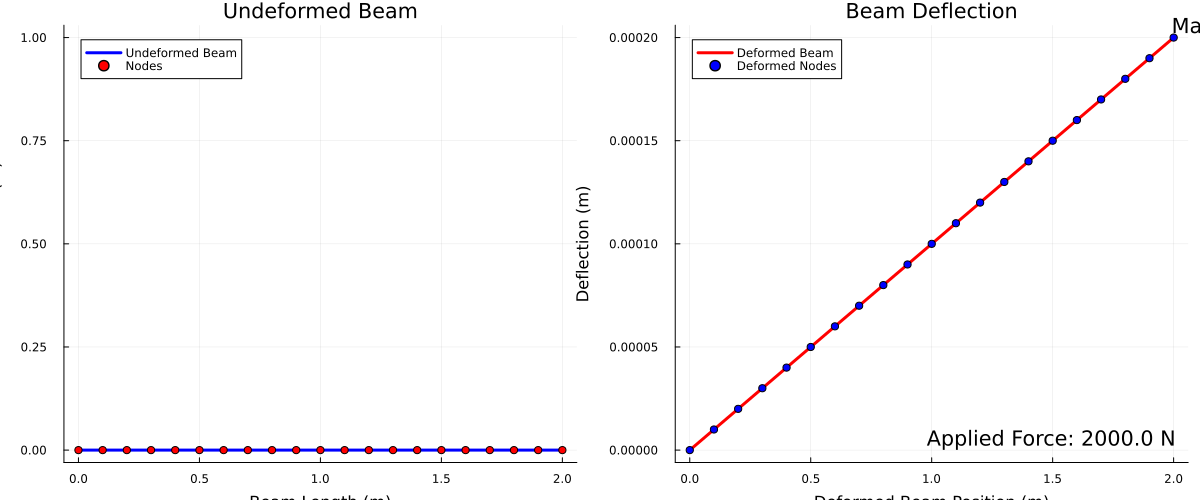

Maximum deflection (FEA): 0.0002000000000007121 meters
Predicted maximum deflection (ML): [0.0001418721652767736] meters


42-element Vector{Float64}:
 0.0
 0.0
 5.000000000036178e-7
 1.0000000000071863e-5
 2.0000000000140916e-6
 2.000000000013712e-5
 4.500000000030948e-6
 3.0000000000199518e-5
 8.000000000053891e-6
 4.0000000000258857e-5
 1.2500000000082664e-5
 5.00000000003161e-5
 1.8000000000117135e-5
 ⋮
 0.00011250000000063203
 0.00015000000000069762
 0.0001280000000007021
 0.00016000000000070306
 0.00014450000000077262
 0.0001700000000007073
 0.00016200000000084357
 0.0001800000000007113
 0.00018050000000091476
 0.00019000000000071222
 0.000200000000000986
 0.0002000000000007121

In [25]:
main()